## Hand Writing Digit Recognition in Deep Learning

This notebook attempt to develop a hand writing image recognition solution by using deep learning - CNN framework.  
Solving MNIST handwritten digits images to their correct label with high accuracy is the goal of this solution..

This notebook is inspired from many deep learning fans and practionairers best practices and other training materials.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
import keras.layers.core as core
import keras.layers.convolutional as conv
import keras.models as models
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# one-hot-encoding convertion
from keras.utils.np_utils import to_categorical 
import keras.utils.np_utils as kutils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set seed
seed = 5
np.random.seed(seed)

Using TensorFlow backend.


**Load train and test data from disk**

In [2]:
#read data files into pandas dataframe
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
#does some basic data quality checking
print(train.shape, test.shape)
train.tail()

(42000, 785) (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check if any empty values exist in both train and test file

In [3]:
#any empty values?
# train.isnull().sum()
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [4]:
#test.isnull().sum()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

![](http://)**Data Preparation**
this is usually the most important part of modelling, ensure the data is correct first before do any modelling work.

In [5]:
# ensure traing data using correct data type. 
# note: use 16bits could potentially save more GPU memory space
X_train = (train.iloc[:,1:].values).astype('float32') 
y_train = train.iloc[:,0].values.astype('int32') 

# change train datset format to keras format 
X_train = X_train.reshape(-1, 28, 28,1)
# normalize the data to grayscale to reduce effect of illumination's diffencens
X_train = X_train / 255.0
print(X_train.shape , y_train.shape)

#make same update for test data
test = test.values.reshape(-1, 28, 28, 1)
test = test.astype(float)
# normalize the data to grayscale to reduce effect of illumination's diffencens
test /= 255.0
print (test.shape)

(42000, 28, 28, 1) (42000,)
(28000, 28, 28, 1)


In [6]:
# one-hot vector for training labels classes
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
print ("Number of classes: ",num_classes)

Number of classes:  10


In [7]:
# split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state=seed)
print ("Shapes of train, validation dataset ")
print(X_train.shape , Y_train.shape)
print(X_val.shape , Y_val.shape)

Shapes of train, validation dataset 
(37800, 28, 28, 1) (37800, 10)
(4200, 28, 28, 1) (4200, 10)


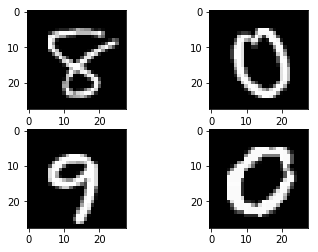

In [8]:
# view few example data
for i in range(1,5):
    plt.subplot(2,2,i)
    g = plt.imshow(X_train[i][:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

![](http://)**Build a CNN model**  CNNs are extremely efficient for images and proven.

the Keras Sequential API, to add one layer at a time, starting from the input.
 First convolutional (Conv2D) layer which is a set of 32 learnable filters follow by another 64 filters for the last two layers. with Convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image, add a dropout then follow by 2 fully connected layers. 
 
  [ Convolution2D -> Convolution2D -> Max Pool --> Convolution2D--> Convolution2D --> Max Pool--> Flatten --> [DropOut] --> Dense --> Dense ]
  
  Note:
  Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training.
  However, this value can not be too small, less than 20% may be get ignored or not effect. 

In [9]:
# adj parameters
filters_1 = 32 
filters_2 = 64 
filters_3 = 128 

# Create model
model = models.Sequential()
model.add(conv.Convolution2D(filters_1, (3,3),  activation="relu", input_shape=(28, 28, 1), border_mode='same'))
model.add(conv.Convolution2D(filters_1, (3,3), activation="relu", border_mode='same'))
model.add(conv.MaxPooling2D(strides=(2,2)))
model.add(conv.Convolution2D(filters_2,(3,3), activation="relu", border_mode='same'))
model.add(conv.Convolution2D(filters_2, (3,3), activation="relu", border_mode='same'))
model.add(conv.MaxPooling2D(strides=(2,2)))
model.add(core.Flatten())
model.add(core.Dropout(0.2))
model.add(core.Dense(128, activation="relu"))
model.add(core.Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adamax", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

**Train Model**

In [10]:
%%time
# best practice tips
print ("apply augumentation or data noisy...")
# apply data augmentation to create noisy on data which increase accuracy
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

print ("training started...")
# Train
epochs = 16 
batch_size = 128
# callback checkpoint
checkpoint = ModelCheckpoint('model-best-trained.h5', verbose=0, monitor='loss',save_best_only=True, mode='auto')  
# callback learning rate reducer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.4, min_lr=0.00001)
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,checkpoint])
print ("training finished!")

apply augumentation or data noisy...
training started...
Epoch 1/16
295/295 [==============================] - 12s 41ms/step - loss: 0.4097 - acc: 0.8698 - val_loss: 0.0758 - val_acc: 0.9760
Epoch 2/16
295/295 [==============================] - 10s 35ms/step - loss: 0.1242 - acc: 0.9625 - val_loss: 0.0570 - val_acc: 0.9817
Epoch 3/16
295/295 [==============================] - 11s 37ms/step - loss: 0.0907 - acc: 0.9718 - val_loss: 0.0472 - val_acc: 0.9857
Epoch 4/16
295/295 [==============================] - 11s 36ms/step - loss: 0.0739 - acc: 0.9784 - val_loss: 0.0421 - val_acc: 0.9876
Epoch 5/16
295/295 [==============================] - 11s 37ms/step - loss: 0.0621 - acc: 0.9806 - val_loss: 0.0333 - val_acc: 0.9893
Epoch 6/16
295/295 [==============================] - 11s 36ms/step - loss: 0.0561 - acc: 0.9829 - val_loss: 0.0390 - val_acc: 0.9895
Epoch 7/16
295/295 [==============================] - 10s 35ms/step - loss: 0.0487 - acc: 0.9846 - val_loss: 0.0359 - val_acc: 0.9898
Epoch

model evaluation score: acc: 99.31%


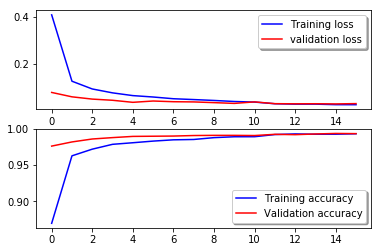

In [11]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

score = model.evaluate(X_val, Y_val, verbose=0)
print("model evaluation score: %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

**Run Prediction**

In [12]:
# Predict
print ("Running prediction test....")
predictions = model.predict_classes(test,verbose=1)
print ("done")

Running prediction test....
28000/28000 [==============================] - 3s 120us/step
done


**Save result to file**

In [13]:
# save file using numpy
np.savetxt('digits-mnist-cnn-1.csv', np.c_[range(1,len(predictions)+1),predictions], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')
print ("saved prediction to file")
sub = pd.read_csv("digits-mnist-cnn-1.csv")
sub.tail(10)

saved prediction to file


,ImageId,Label
27990,27991,7
27991,27992,6
27992,27993,1
27993,27994,9
27994,27995,7
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [14]:
# save file using data-frame
submission_result_file="digits-mnist-cnn-2.csv"
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),"Label": predictions})
submissions.to_csv(submission_result_file, index=False, header=True)
print ("saved prediction to file")
submissions.tail(10)

saved prediction to file


,ImageId,Label
27990,27991,7
27991,27992,6
27992,27993,1
27993,27994,9
27994,27995,7
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


Thanks for reading! 
Welcome any comments or suggestion.  thanks!